# Init Attribution Class

In [3]:
#load datasets
import geopandas as gpd
import pandas as pd
from constants import loading_dict, temporal_buffer, ddataset_profile, ddisturbance_profile, DCLASS_SCORE, dtypes, doa, dsbuffer

ddataset = {dataset_name : gpd.read_parquet(dataset_path) for dataset_name, dataset_path in loading_dict.items()}

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#preprocessing bdiff:

ddataset['firepolygons']['class'] = 'Fire'
#add end date with offset of 7 days 
ddataset['firepolygons']['end_date'] = pd.to_datetime(ddataset['firepolygons']['start_date']) + pd.to_timedelta(7, unit='d')

ddataset['bdiff']['class'] = 'Fire'
ddataset['bdiff'] = ddataset['bdiff'][ ddataset['bdiff'].forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d',
#filter bdiff geometry area < 100 1e6  m2
ddataset['bdiff'] = ddataset['bdiff'][ ddataset['bdiff'].geometry.area <= 100e6 ]
#same for cdi 
ddataset['cdi'] = ddataset['cdi'][ ddataset['cdi'].geometry.area <= 100e6 ] 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


ddataset['bdiff'][['start_date', 'end_date']] = ddataset['bdiff'].apply(to_datetime_safe, axis=1, result_type='expand')

#autoreload 
from attribution2 import Attribution
attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)

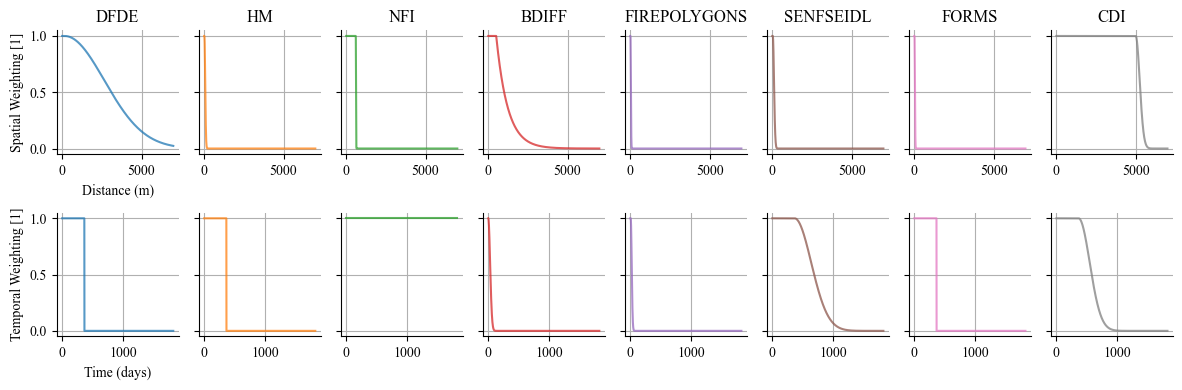

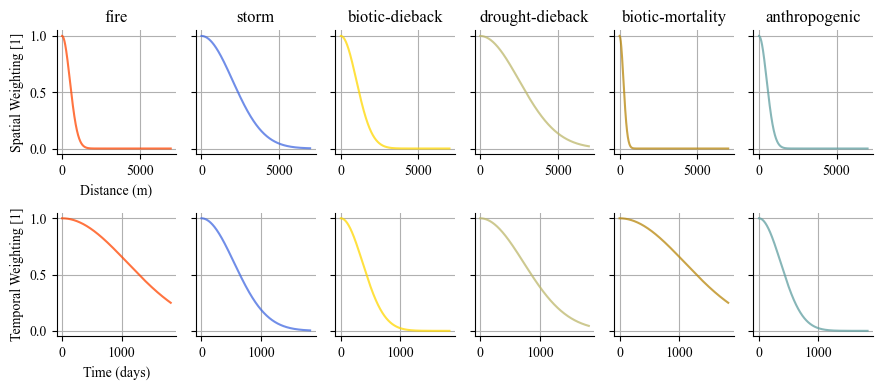

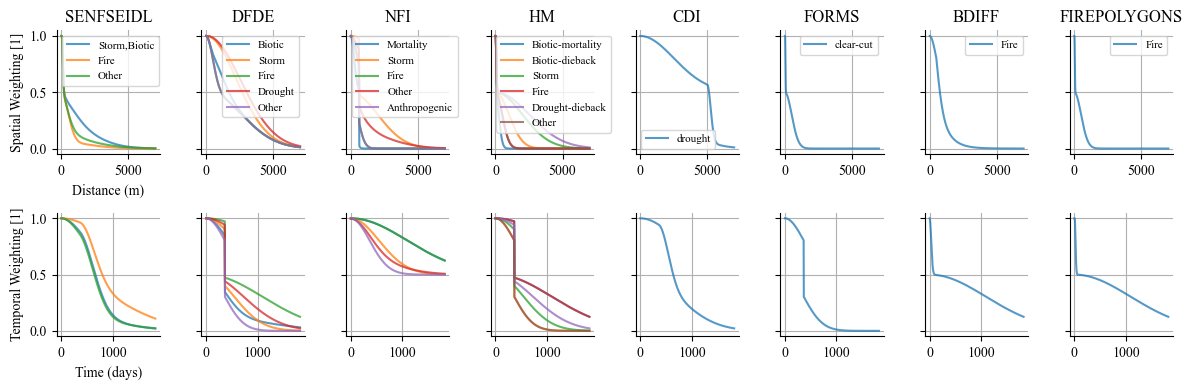

(<Figure size 1200x400 with 16 Axes>,
 <Figure size 900x400 with 12 Axes>,
 <Figure size 1200x400 with 16 Axes>)

In [9]:
attribution.plot_weighting_functions()

# Weighting profiles

In [1]:
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ajouter tree-specie
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok


#preprocessing bdiff:
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#autoreload 
from attribution import Attribution
from constants import DCLASS_SCORE

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('offset_gaussian', {'offset': 150, 'decrease': 5000}), #offset srt( min(area) / pi), k sqrt(median(area) / pi)
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'hm': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 100}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'nfi': {
        'spatial': ('offset_gaussian', {'offset': 600, 'decrease': 25}),
        'temporal': ('step', {'start': 0, 'end': 5 * 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 30})
    },
    'senfseidl': {
        'spatial': ('offset_gaussian', {'offset': 30, 'decrease': 5 * 30}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 1.5 * 365})
    },
    'forms': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 5*10}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'reference': {
        'spatial': ('offset_gaussian', {'offset': 0, 'decrease': 3 * 50}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'cdi': {
        'spatial': ('offset_gaussian', {'offset': 5000, 'decrease': 500}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 365})
    },
}

#visible disturbances
ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1.5 * 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 365})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 2*365})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'anthropogenic': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1 * 365})
    }
}

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': 1., 'bdiff': 1.0, 'cdi':1.0, 'forms':1.0}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100}

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 174.72 km2, median : 25.00 km2
senfseidl  -  Storm,Biotic
senfseidl  -  Fire
senfseidl  -  Other
dfde  -  Biotic
dfde  -  Storm
dfde  -  Fire
dfde  -  Drought
dfde  -  Other
nfi  -  Mortality
nfi  -  Storm
nfi  -  Fire
nfi  -  Other
nfi  -  Anthropogenic
hm  -  Biotic-mortality
hm  -  Biotic-dieback
hm  -  Storm
hm  -  Fire
hm  -  Drought-dieback
hm  -  Other
cdi  -  drought
forms  -  clear-cut
bdiff  -  Fire
reference  -  None


In [2]:
dataset = 'nfi'
c = 'Other'

ddataset_profile = attribution.ddataset_profile[dataset]['spatial'] 

attribution.final_weighting_dict[dataset][c]['spatial'] 

<function utils.get_combined_weighting.<locals>.<lambda>(x)>

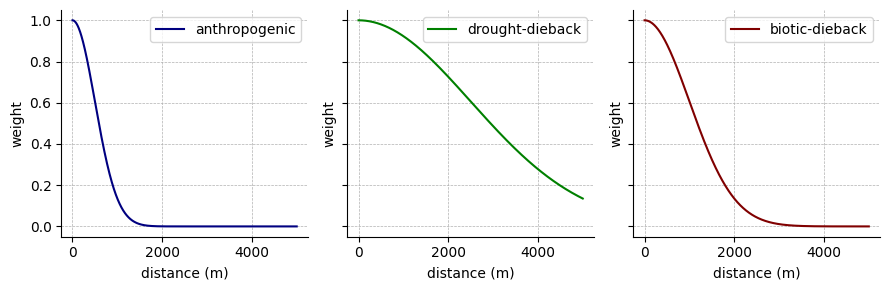

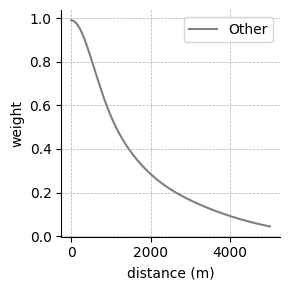

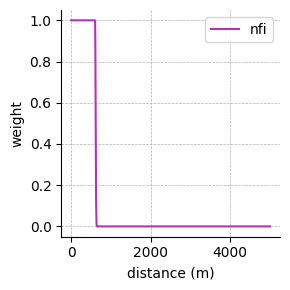

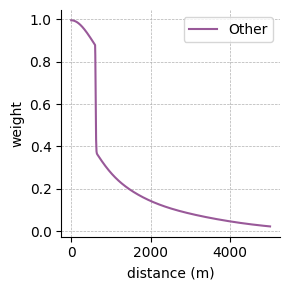

In [15]:
from constants import DCLASS_SCORE
from utils import dfunction
import matplotlib.pyplot as plt
import numpy as np 

x = np.linspace(0, 5000, 1000)

#disturbances profiles 
fig1, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
color = [(0,0,0.5), (0,0.5,0), (0.5,0,0), (0.5,0.5,0.5), (0.7,0.2,0.7), (0.6,0.35,0.6)]
n = len(DCLASS_SCORE[dataset][c])
for i,subclass  in enumerate(DCLASS_SCORE[dataset][c]):
    func_name, args = attribution.ddisturbance_profile[subclass]['spatial']
    y = [dfunction[func_name](xi, **args) for xi in x]
    axes[i].plot(x, y, label=subclass, color=color[i])

for ax in axes:
    ax.set_xlabel('distance (m)')
    ax.set_ylabel('weight')
    ax.legend()
    #remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(linestyle='--', lw=0.5)

plt.tight_layout()
plt.show()

#combination 
from utils import combine_functions
disturbance_funcs_scores = [(attribution.ddisturbance_profile[disturbance_class]['spatial'], score) for disturbance_class, score in DCLASS_SCORE[dataset][c].items()]
disturbance_funcs = [lambda x, f=dfunction[fn], p=p: f(x, **p) for (fn, p), _ in disturbance_funcs_scores]
scores = [score for _, score in disturbance_funcs_scores]

combined_disturbance_func = combine_functions(disturbance_funcs, scores)
y = [combined_disturbance_func(xi) for xi in x]
fig2, axes = plt.subplots(1, 1, figsize=(3, 3), sharey=True)
axes.plot(x, y, label=c, color=color[3])
axes.set_xlabel('distance (m)')
axes.set_ylabel('weight')
axes.legend()
#remove top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.grid(linestyle='--', lw=0.5)
plt.tight_layout()
plt.show()

#dataset profile
func_name, args = attribution.ddataset_profile[dataset]['spatial']
y = [dfunction[func_name](xi, **args) for xi in x]
fig3, axes = plt.subplots(1, 1, figsize=(3, 3), sharey=True)
axes.plot(x, y, label=dataset, color=color[4])
axes.set_xlabel('distance (m)')
axes.set_ylabel('weight')
axes.legend()
#remove top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.grid(linestyle='--', lw=0.5)
plt.tight_layout()
plt.show()

#final weighting
fig4, axes = plt.subplots(1, 1, figsize=(3, 3), sharey=True)
y = [attribution.final_weighting_dict[dataset][c]['spatial'](xi) for xi in x]
axes.plot(x, y, label=c, color=color[5])
axes.set_xlabel('distance (m)')
axes.set_ylabel('weight')
axes.legend()
#remove top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.grid(linestyle='--', lw=0.5)
plt.tight_layout()
plt.show()

In [16]:
fig1.savefig(f'../figures/ex_disturbance_profiles_{dataset}_{c}.png', dpi=300)
fig2.savefig(f'../figures/ex_combined_disturbance_profile_{dataset}_{c}.png', dpi=300)
fig3.savefig(f'../figures/ex_dataset_profile_{dataset}_{c}.png', dpi=300)
fig4.savefig(f'../figures/ex_final_weighting_{dataset}_{c}.png', dpi=300)

# Louvain communities

In [2]:
#load communities 
dim = 2
resolution = 100
spatial_threshold = 600
temporal_threshold = 360

from shapely import box
from shapely.geometry import shape 
import numpy as np
bounds_4326 = (4.75,47.10,6.82,48.51)
pol_4326 = box(*bounds_4326)
import rasterio 
from rasterio.warp import transform_geom
pol_2154 = shape(transform_geom('epsg:4326', attribution.dataset.crs, pol_4326))
_dataset = attribution.dataset.clip(pol_2154)
n = _dataset.shape[0] / attribution.dataset.shape[0] * 100
_spatial_entity_dataset = attribution.spatial_entity_dataset.clip(pol_2154)
m = _spatial_entity_dataset.shape[0] / attribution.spatial_entity_dataset.shape[0] * 100
b = "_".join([str(x) for x in bounds_4326])

all_clusters_gdf = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")
c = all_clusters_gdf.shape[0] / (_spatial_entity_dataset.shape[0] + _dataset.shape[0] )
print(c)

0.9983590520369845


In [13]:
all_clusters_gdf_v2 = all_clusters_gdf.rename(columns={'class': 'cause'})
all_clusters_gdf_v2.geometry = all_clusters_gdf_v2.geometry.centroid
subpart = all_clusters_gdf_v2.iloc[4000:4250]

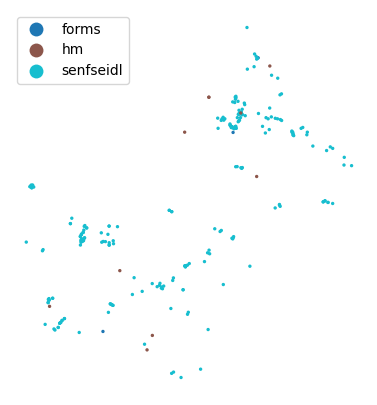

In [74]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

subpart.plot(ax=ax, column='dataset', markersize=2, legend=True)
ax.set_axis_off()
fig.savefig('../figures/example_subgraph.png', dpi=300)

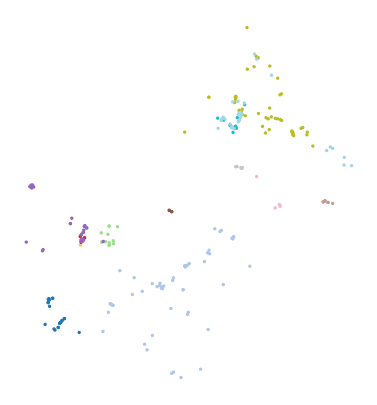

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))


subpart.plot(ax=ax, column='cluster', markersize=2, cmap='tab20')
ax.set_axis_off()
fig.savefig('../figures/example_subgraph_louvain_communities.png', dpi=300)

In [45]:
subpart.cluster.unique()

array([226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238])

<Axes: >

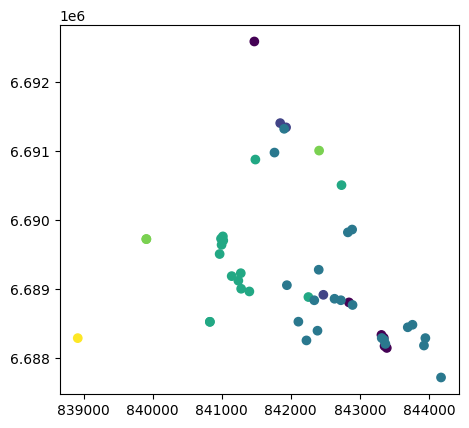

In [39]:
import pandas as pd
subpart.centroid_date = pd.to_datetime(subpart.centroid_date).dt.year
subpart[ subpart.cluster == 236 ].plot(column='centroid_date') #236 #227

In [16]:
from utils import compute_class_similarity_v2, compute_spatial_distance_v2, compute_tree_coherence_v2
weights = {
    'equal' : [0.25, 0.25, 0.25, 0.25],
    'PCA' : [0.23017731, 0.40759976, 0.20566699, 0.15655594],
    'ECO' : [2, 2, 1, 3]
}
method = 'DBSCAN'
filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)
dcustom_similarity_function_v2 = {'spatial_distance': (compute_spatial_distance_v2, {'final_weighting_dict': attribution.final_weighting_dict}), 
                                  'tree_coherence': (compute_tree_coherence_v2, {'filter_cause': filter_class}), 
                                  'class_similarity': (compute_class_similarity_v2, {'dclass_score': DCLASS_SCORE})}

In [58]:
from constants import DCLASS_SCORE
from utils import get_matrices_v2, build_similarity_v2, get_cluster_v2  
weight = weights['equal']
method = 'HDBSCAN'
kwargs = {'min_cluster_size': 2}
data = subpart[ subpart.cluster == 236 ] #227
matrice = get_matrices_v2(data,  dtypes, dcustom_similarity_function_v2, attribution.final_weighting_dict)
similarity = build_similarity_v2(matrice, weight)
gdf, _, labels = get_cluster_v2(data, similarity, attribution.final_weighting_dict, attribution.doa, DCLASS_SCORE, method=method, method_kwargs=kwargs) 


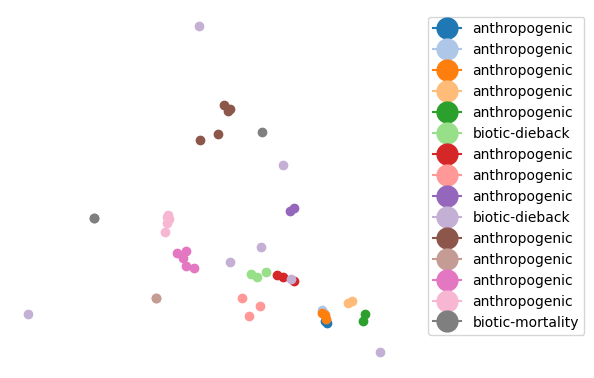

In [93]:
#HDBSCAN
from matplotlib.lines import Line2D

legend = []
labels = []
cm = plt.get_cmap('tab20')
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i, (name, row) in enumerate(gdf.iterrows()):
    color = cm(i/20)
    subgdf = data.loc[row['Indexes']]
    subgdf.plot(ax=ax, color=color)
    subgdf.geometry.centroid.centroid
    legend.append( Line2D([0], [0], marker='o', color=color, label='Scatter',
                          markerfacecolor=color, markersize=15) )
    labels.append(row['Class'])
    

ax.set_axis_off()
legend = ax.legend(legend, labels, bbox_to_anchor=(1.5, 1))
fig.savefig('../figures/example_subgraph_HDBSCAN.png', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
#

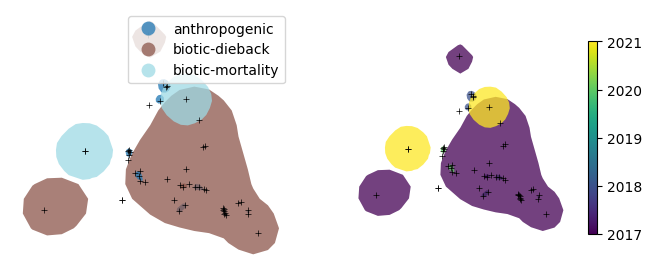

In [91]:
#Spatial and Temporal closed forms estimation of disturbance clusters from reliability profiles
import matplotlib.pyplot as plt
plt.ion()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

#ax1
gdf.plot(column='Class', cmap='tab20', ax=ax1, legend=True, alpha=0.75)
data.plot(ax=ax1, marker='+', color='k', markersize=15, lw=0.5)
#ax2 
gdf['Year'] = pd.to_datetime(gdf.Start_Date).dt.year
gdf.plot(column='Year', ax=ax2, legend=True, alpha=0.75, legend_kwds={'shrink': 0.5})
data.plot(ax=ax2, marker='+', color='k', markersize=15, lw=0.5)

for ax in [ax1, ax2]:
    ax.set_axis_off()

fig.savefig('../figures/example_subgraph_reliability_zone.png', dpi=300)


# Clustering & Disturbance zone

In [65]:
#load communities 
dim = 2
resolution = 100
spatial_threshold = 600
temporal_threshold = 360

from shapely import box
from shapely.geometry import shape 
import numpy as np
bounds_4326 = (4.75,47.10,6.82,48.51)
pol_4326 = box(*bounds_4326)
import rasterio 
from rasterio.warp import transform_geom
pol_2154 = shape(transform_geom('epsg:4326', attribution.dataset.crs, pol_4326))
_dataset = attribution.dataset.clip(pol_2154)
n = _dataset.shape[0] / attribution.dataset.shape[0] * 100
_spatial_entity_dataset = attribution.spatial_entity_dataset.clip(pol_2154)
m = _spatial_entity_dataset.shape[0] / attribution.spatial_entity_dataset.shape[0] * 100
b = "_".join([str(x) for x in bounds_4326])

all_clusters_gdf = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")
c = all_clusters_gdf.shape[0] / (_spatial_entity_dataset.shape[0] + _dataset.shape[0] )
print(c)

0.9983590520369845


2771


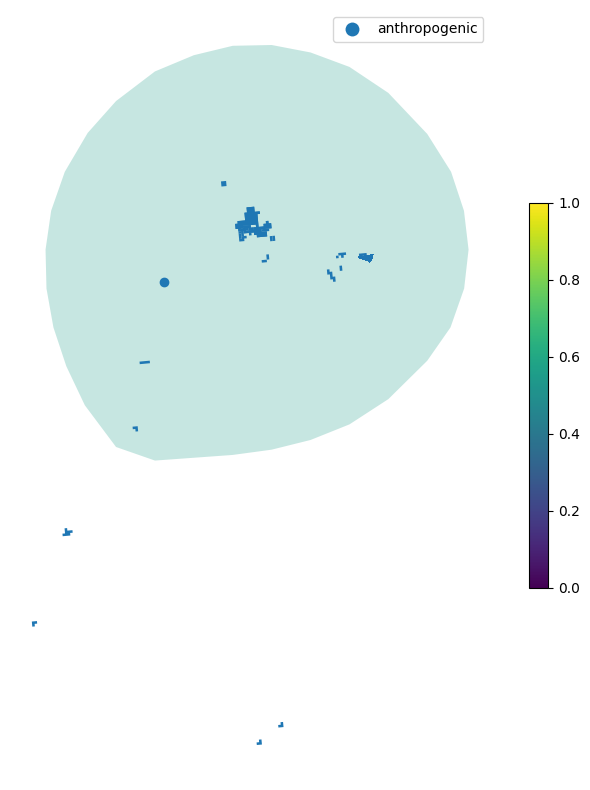

In [163]:
clusters = all_clusters_gdf.rename(columns={'class': 'cause'})
clusters = clusters[ clusters.start_date.dt.year > 2017]
c = clusters.cluster.unique()
#random cluster
import random
r = random.choice(c)
print(r)
sub = clusters[ clusters.cluster ==  r]

from utils import compute_class_similarity_v2, compute_spatial_distance_v2, compute_tree_coherence_v2
weights = {
    'equal' : [0.25, 0.25, 0.25, 0.25],
    'PCA' : [0.23017731, 0.40759976, 0.20566699, 0.15655594],
    'ECO' : [2, 2, 1, 3]
}
kwds = {
    'DBSCAN': {'eps': 0.7, 'min_samples': 2},
    'HDBSCAN': {'min_cluster_size': 2}
}

filter_class = set()
for dataset, dclass in DCLASS_SCORE.items():
    for class_ in dclass:
        if 'storm' in dclass[class_] or 'fire' in dclass[class_]:
            filter_class.add(class_)
dcustom_similarity_function_v2 = {'spatial_distance': (compute_spatial_distance_v2, {'final_weighting_dict': attribution.final_weighting_dict}), 
                                  'tree_coherence': (compute_tree_coherence_v2, {'filter_cause': filter_class}), 
                                  'class_similarity': (compute_class_similarity_v2, {'dclass_score': DCLASS_SCORE})}

from constants import DCLASS_SCORE
from utils import get_matrices_v2, build_similarity_v2, get_cluster_v2  
weight = weights['equal']
method = 'DBSCAN'
kwargs = kwds[method]
data = sub
matrice = get_matrices_v2(data,  dtypes, dcustom_similarity_function_v2, attribution.final_weighting_dict)
similarity = build_similarity_v2(matrice, weight)
gdf, _, labels = get_cluster_v2(data, similarity, attribution.final_weighting_dict, attribution.doa, DCLASS_SCORE, method=method, method_kwargs=kwargs) 

#show
all_indexes = []
list_gdf = []
for name, row in gdf.iterrows():
    g = all_clusters_gdf[all_clusters_gdf.index.isin(row.Indexes)]
    g['Cluster_Class'] = row['Class']
    list_gdf.append(g)

gdf_polygons = gpd.GeoDataFrame(pd.concat(list_gdf), geometry='geometry', crs=gdf.crs)
gdf_polygons.drop(['centroid_date'],axis=1, inplace=True)

plt.ion()
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

gdf.plot(ax=ax, column='IntraSimilarity', legend=True, cmap='viridis', alpha=0.25, legend_kwds={'shrink': 0.5}, vmin=0, vmax=1)
gdf_polygons.plot(column='Cluster_Class', ax=ax, legend=True, cmap='tab20')
ax.set_axis_off()

In [161]:
#1578 1209 3261 2939 3305 444 1596 3516 1818 528
#keep the following clusters numbers
c = [1578, 1209, 3261, 2939, 3305, 444, 1596, 3516, 1818, 528]
clusters_samples = all_clusters_gdf[ all_clusters_gdf.cluster.isin(c) ]
#save as sample_downlaod_clusters.parquet 
clusters_samples.to_parquet('sample_download_clusters.parquet')

# Final output

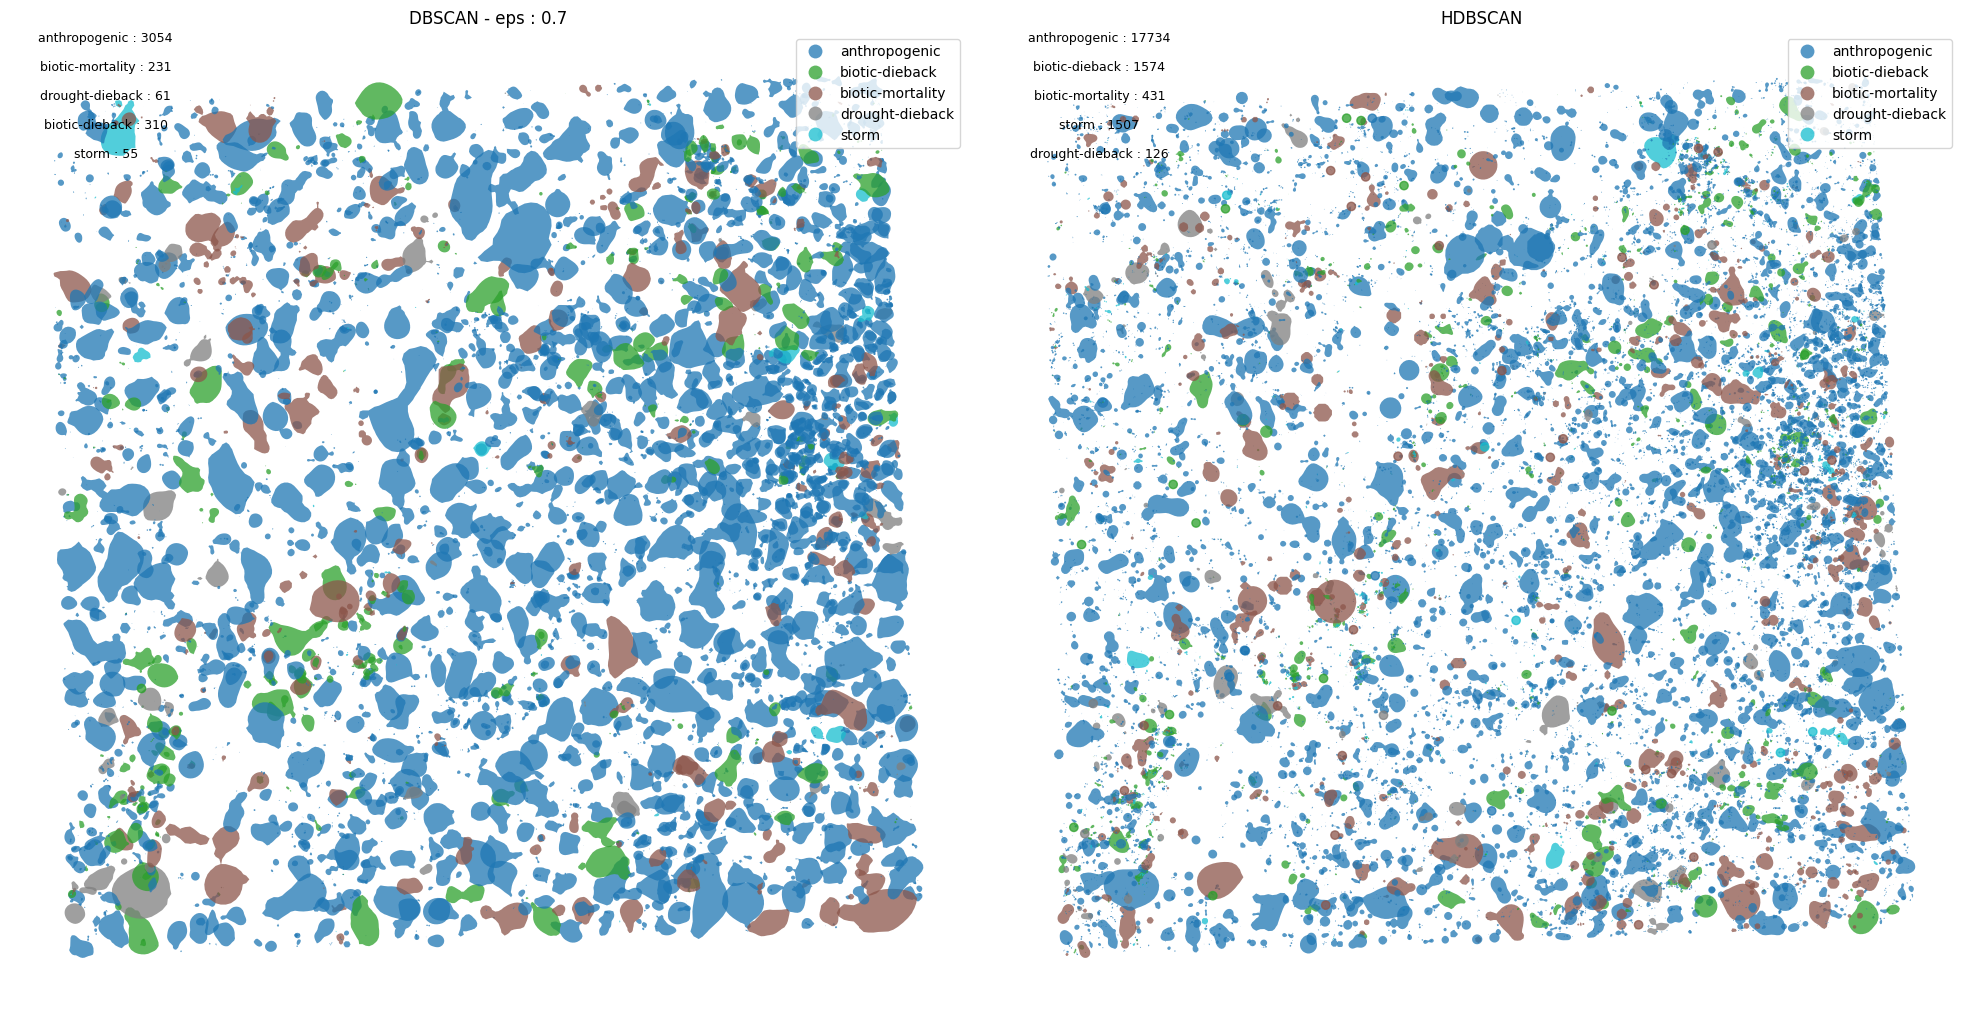

In [64]:
import matplotlib.pyplot as plt
from utils import calculate_temporal_centroid

temporal_threshold = 180 * 2
spatial_threshold = 600
resolution = 100
bounds_4326 = (4.75,47.10,6.82,48.51)
b = "_".join([str(x) for x in bounds_4326])
n, m = int(8.353069463256475), 3
fig, axes = plt.subplots(1, 2, figsize=(20,10))
mode = 'PCA'
spatial_dx = 50
j = 1
dim = 2
dict_gdf = {}
for ax, method in zip(axes, ['DBSCAN', 'HDBSCAN']):
    gdf = gpd.read_parquet(f"../data/results/clusters/clusters_{method}_m{mode}_sn{spatial_dx}_{j}_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold}m_{temporal_threshold}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.parquet")
    dict_gdf[method] = gdf
    gdf.plot(ax=ax, column='Class', alpha=0.75, legend=True)
    ax.set_axis_off()
    if method == 'DBSCAN':
        ax.set_title(f'{method} - eps : 0.7')
    else :
        ax.set_title(f'{method}')
    #add value counts for each label as annotation
    for i, label in enumerate(gdf['Class'].unique()):
        ax.annotate(f'{label} : {gdf[gdf["Class"] == label].shape[0]}', xy=(0.1, 0.99-i*0.03), xycoords='axes fraction', ha='center', fontsize=9)

# for ax, method in zip(axes[1], ['DBSCAN', 'HDBSCAN']):
#     gdf = dict_gdf[method]
#     gdf['year'] = gdf.apply(lambda x : calculate_temporal_centroid(x.Start_Date, x.End_Date), axis=1).dt.year
#     gdf.plot(ax=ax, column='year', alpha=0.75, legend=True, legend_kwds={'shrink': 0.5}, vmin=2013)
#     ax.set_axis_off()
#     ax.set_title(f'{method}')
#     #add value counts for each label as annotation
#     for i, label in enumerate(sorted(gdf['year'].unique())):
#         ax.annotate(f'{label} : {gdf[gdf["year"] == label].shape[0]}', xy=(0.9, 0.99-i*0.03), xycoords='axes fraction', ha='center', fontsize=9)

plt.tight_layout()
#fig.savefig(f'../data/results/clusters/comparison_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}_b{b}_n{n :.0f}_m{m :.0f}.png', dpi=200)

# Comparison between algorithm 

In [1]:
import pickle
method = ['DBSCAN', 'HDBSCAN']
kwds = {
    'DBSCAN': ({'eps': 0.7, 'min_samples': 2}, {'eps': 0.23, 'min_samples': 2}),
    'HDBSCAN': ({'min_cluster_size': 2},)
}

vars = ['ami_scores', 'ari_scores', 'dict_labels', 'dict_labels_size', 'dict_noise', 'dict_silhouette']

dir_ = '/Users/arthurcalvi/Repo/Disturbance-Attribution-Dataset-Joining/data/results/dict'
super_dict = {}
for method in ['DBSCAN', 'HDBSCAN']:
    super_dict[method] = {}
    for kwd in kwds[method]:
        super_dict[method][str(kwd)] = {}
        #load with pickle
        for var in vars: 
            with open(f"{dir_}/{var}_{method}_kwds{str(kwd)}.pkl", 'rb') as f:
                values = pickle.load(f)
            super_dict[method][str(kwd)][var] = values
        

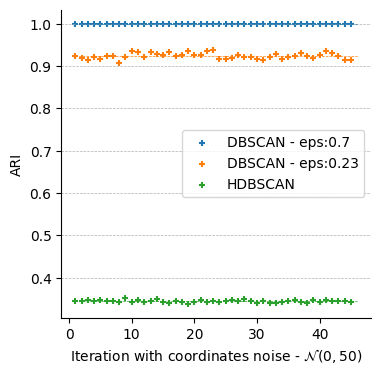

In [2]:
import matplotlib.pyplot as plt
import numpy as np
weighting = 'equal'

#plot ARI index 
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
i = 0 
for method in ['DBSCAN', 'HDBSCAN']:
    for kwd in kwds[method]:
        values = super_dict[method][str(kwd)]['ari_scores'][weighting]
        if method == 'DBSCAN':
            eps = kwd['eps']
            label = f'{method} - eps:{eps}'
        else :
            label = f'{method}'
        ax.scatter(range(1, len(values)+1), values, label=label, marker='+', color=f'C{i}', s=15)
        ax.hlines(np.mean(values), 1, len(values)+1, linestyle='--', color=f'C{i}', lw=0.5)
        i+=1

ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r'Iteration with coordinates noise - $\mathcal{N}(0, 50)$')
ax.set_ylabel('ARI')
#just horizontal grid
ax.grid(axis='y', linestyle='--', lw=0.5)

/var/folders/1c/h8t9_vd53gsgz_wm9kswm8wm0000gp/T/ipykernel_3561/3552490389.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


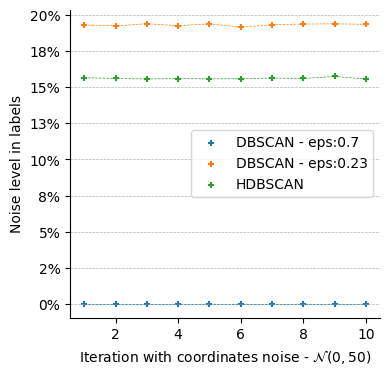

In [3]:
#same figure with noise level in labels
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
i = 0
for method in ['DBSCAN', 'HDBSCAN']:
    for kwd in kwds[method]:
        values = super_dict[method][str(kwd)]['dict_noise'][weighting]
        if method == 'DBSCAN':
            eps = kwd['eps']
            label = f'{method} - eps:{eps}'
        else :
            label = f'{method}'
        ax.scatter(range(1, len(values)+1), values, label=label, marker='+', color=f'C{i}', s=15)
        ax.plot(range(1, len(values)+1), values, linestyle='--', color=f'C{i}', lw=0.5)
        i+=1

ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(r'Iteration with coordinates noise - $\mathcal{N}(0, 50)$')
ax.set_ylabel('Noise level in labels')
#change y to percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
#just horizontal grid
ax.grid(axis='y', linestyle='--', lw=0.5)

In [6]:
len(axes[0])

10

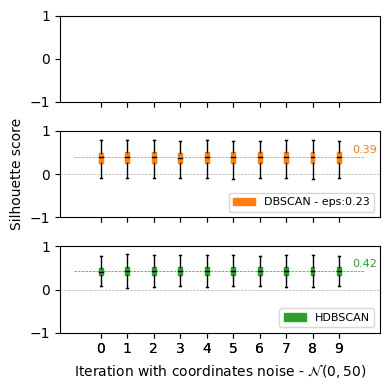

In [45]:
#adapt the code above for silhouette score 
#same for silhouette score but those are distribution for each iteration, so we need to show a distribution per iteration per methods per kwd, maybe use boxplot
#use 3 different subplots for each method
#create on subplot for each iteration also and share y axis so in total 10 columsn and 3 rows
#adapt the following code

fig, axes = plt.subplots(3, 1, figsize=(4, 4), sharex=True, sharey=True)
i = 0
for method in ['DBSCAN', 'HDBSCAN']:
    for kwd in kwds[method]:
        silhouette = super_dict[method][str(kwd)]['dict_silhouette'][weighting]
        if len(silhouette[0]) == 0:
            pass
            i+=1
        else:
    
            # Plotting silhouette scores
            for j, silhouette_list in enumerate(silhouette):
                axes[i].boxplot(silhouette_list, positions=[j], patch_artist=True, boxprops=dict(facecolor=f'C{i}', color=f'C{i}'), medianprops=dict(color='k'), showfliers=False)

            #add median of all silhouette distirbution
            median = np.median(np.concatenate(silhouette))
            axes[i].hlines(median, -1, len(silhouette), linestyle='--', color=f'C{i}', lw=0.5)
            #add annotation with median value and with the right color
            axes[i].annotate(f'{median:.2f}', xy=(len(silhouette), median), xytext=(len(silhouette)-0.5, median+0.1), color=f'C{i}', fontsize=8)

            #add legend with label
            if method == 'DBSCAN':
                eps = kwd['eps']
                label = f'{method} - eps:{eps}'
            else :
                label = f'{method}'
            #add custom legend with label and patch 
            axes[i].legend([f'{label}'], loc='lower right', fontsize=8)
            axes[i].set_ylim(-1, 1)
            axes[i].grid(axis='y', linestyle='--', lw=0.5)         
            i+=1

#add x and y labels
axes[2].set_xlabel(r'Iteration with coordinates noise - $\mathcal{N}(0, 50)$')
axes[1].set_ylabel('Silhouette score')
plt.tight_layout()

Text(0, 0.5, 'Cluster size')

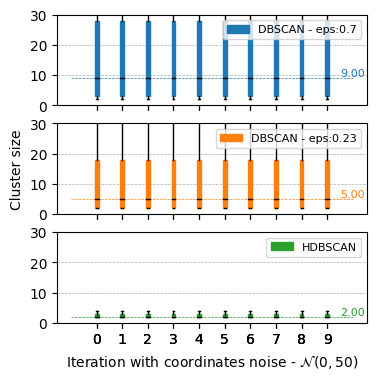

In [59]:
#same thing but with label_size

fig, axes = plt.subplots(3, 1, figsize=(4, 4), sharex=True, sharey=True)
i = 0
for method in ['DBSCAN', 'HDBSCAN']:
    for kwd in kwds[method]:
        label_size = super_dict[method][str(kwd)]['dict_labels_size'][weighting]
        if len(label_size[0]) == 0:
            pass
            i+=1
        else:
    
            # Plotting silhouette scores
            for j, label_size_list in enumerate(label_size):
                axes[i].boxplot(label_size_list, positions=[j], patch_artist=True, boxprops=dict(facecolor=f'C{i}', color=f'C{i}'), medianprops=dict(color='k'), showfliers=False)

            #add median of all silhouette distirbution
            median = np.median(np.concatenate(label_size))
            axes[i].hlines(median, -1, len(label_size), linestyle='--', color=f'C{i}', lw=0.5)
            #add annotation with median value and with the right color
            axes[i].annotate(f'{median:.2f}', xy=(len(label_size), median), xytext=(len(label_size)-0.5, median+0.5), color=f'C{i}', fontsize=8)

            #add legend with label
            if method == 'DBSCAN':
                eps = kwd['eps']
                label = f'{method} - eps:{eps}'
            else :
                label = f'{method}'
            axes[i].set_ylim(0, 30)
            #add custom legend with label and patch 
            axes[i].legend([f'{label}'], loc='upper right', fontsize=8)
            axes[i].grid(axis='y', linestyle='--', lw=0.5)         
            i+=1


#add x and y labels
axes[2].set_xlabel(r'Iteration with coordinates noise - $\mathcal{N}(0, 50)$')
axes[1].set_ylabel('Cluster size')

In [ ]:
#Now a plot with the four subplots above 
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)




# Results on France

In [4]:
#load clusters
mode = 'equal'
method = 'HDBSCAN'
dim = 2
resolution = 100
spatial_threshold_ = 600
temporal_threshold_ = 360
clusters = gpd.read_parquet(f"../data/results/clusters/clusters_{method}_m{mode}_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")

import os
folder = f'../figures/clusters_{method}_m{mode}_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}'
os.makedirs(folder, exist_ok=True)

description of the columns

- IntraSimilarity: The average similarity between the nodes in the same cluster
- Class : class of the cluster (Fire, Storm, Anthropogenic, Biotic-dieback, Drought-diebac, Mortality)
- Indexes : Indexes of the nodes in the cluster (JOIN with TABLE community)
- probabilities : probaility of each index to be part of the cluster (output from HDBSCAN)
- geometry : estimated geometry of the disturbance zone of the cluster in EPSG:2154 
- Spatial_threshold : reliability threshold used to estimate the geometry
- Start_Date, End_Date : estimated start and end date of the disturbance
- Temporal_threshold : reliability threshold used to estimate the start and end date

In [12]:
clusters[ (clusters.Spatial_threshold > 0) & (clusters.Temporal_threshold > 0) ].head(5)

IntraSimilarity          Class                                   Indexes  \
18         0.750000  anthropogenic                          [261894, 261896]   
19         0.722597  anthropogenic                     [69153, 69154, 69155]   
20         0.631004  anthropogenic                          [395078, 395079]   
0          0.566743  anthropogenic  [261090, 261092, 261093, 261095, 261099]   
29         0.564264  anthropogenic                            [69151, 69152]   

                                             geometry  \
18  POLYGON ((766707.566 6654342.211, 766755.242 6...   
19  POLYGON ((766620.078 6654361.552, 766662.223 6...   
20  POLYGON ((766647.711 6654395.224, 766679.129 6...   
0   POLYGON ((762757.984 6653205.495, 762810.494 6...   
29  POLYGON ((765942.104 6653473.951, 765974.922 6...   

                probabilities Start_Date   End_Date  Temporal_threshold  \
18                 [1.0, 1.0] 2017-02-12 2017-11-19            0.977973   
19            [1.0, 1.0, 1.0] 2018-02-11 2018-11-18            0.977783   
20                 [1.0, 1.0] 2019-02-10 2019-11-17            0.977590   
0   [1.0, 1.0, 1.0, 1.0, 1.0] 2017-02-12 2017-11-19            0.977973   
29                 [1.0, 1.0] 2018-02-11 2018-11-18            0.977783   

    Spatial_threshold  
18           0.856284  
19           0.957978  
20           0.975014  
0            0.865109  
29           0.983180

In [3]:
#load communities
communities = gpd.read_parquet(f"../data/results/clusters/communities_d{dim}_r{resolution}_g{attribution.granularity}_{spatial_threshold_}m_{temporal_threshold_}d_v{attribution.version}.parquet")


In [4]:
#convert those coordinates in epsg 4326 TO EPSG:2154 WITH SHAPELY AND RASTERIO
coords = -1.215363,44.271755,-0.856934,44.540569
from shapely.geometry import box, shape
from rasterio.warp import transform_geom

#convert to shapely
pol_4326 = box(*coords)
#convert to 2154
pol_2154 = transform_geom('epsg:4326', 'epsg:2154', pol_4326)

# Les Landes bounding box (using the provided coordinates)
bounds = shape(pol_2154).bounds
les_landes_bbox = {
    'xmin': bounds[0],
    'xmax': bounds[2],
    'ymin': bounds[1],
    'ymax': bounds[3],
}

### 
coords = 5.155334,43.211182,5.630493,43.576411
#convert to shapely
pol_4326 = box(*coords)
#convert to 2154
pol_2154 = transform_geom('epsg:4326', 'epsg:2154', pol_4326)

# Les Landes bounding box (using the provided coordinates)
bounds = shape(pol_2154).bounds
marseille_bbox = {
    'xmin': bounds[0],
    'xmax': bounds[2],
    'ymin': bounds[1],
    'ymax': bounds[3],
}

coords = 5.020752,47.368594,7.844238,49.224773
#convert to shapely
pol_4326 = box(*coords)
#convert to 2154
pol_2154 = transform_geom('epsg:4326', 'epsg:2154', pol_4326)

# Les Landes bounding box (using the provided coordinates)
bounds = shape(pol_2154).bounds
grand_est_bbox = {
    'xmin': bounds[0],
    'xmax': bounds[2],
    'ymin': bounds[1],
    'ymax': bounds[3],
}

bboxs = {'les_landes': les_landes_bbox, 'marseille': marseille_bbox, 'grand-est': grand_est_bbox}

## Cluster Zones

In [16]:
threshold = 0.1
clusters_5 = clusters[  clusters.Spatial_threshold >= threshold]
clusters_5 = clusters_5[  clusters_5.Temporal_threshold >= threshold]

In [17]:
clusters_5['Class'].value_counts()

Class
anthropogenic       194401
storm                 7964
biotic-dieback        5159
fire                  3935
drought-dieback        695
biotic-mortality       537
Name: count, dtype: int64

In [9]:
clusters['Class'].value_counts()

Class
anthropogenic       202789
storm                23143
biotic-dieback        6854
fire                  5314
biotic-mortality      4580
drought-dieback       1147
Name: count, dtype: int64

In [18]:
bbox_name = 'grand-est'
clusters_ = clusters_5 
bbox = bboxs[bbox_name]
#display one fig per year with the clusters
custom_color_mapping = {
    'fire': 'orangered',
    'storm': 'royalblue',
    'biotic-dieback': 'gold',
    'biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'drought-dieback': 'darkkhaki',
    'anthropogenic': 'cadetblue'  # Light blue/grey
}

import os
import matplotlib.pyplot as plt
import contextily as ctx
from tqdm import tqdm
from shapely.geometry import shape
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


for year in tqdm([2017, 2018, 2019, 2020]):
    clusters_year = clusters_[(clusters_.Start_Date.dt.year == year) | (clusters_.End_Date.dt.year == year)]

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for class_, color in custom_color_mapping.items():
        clusters_year[clusters_year.Class == class_].plot(ax=ax, color=color, label=class_, alpha=0.75)

    ax.set_title(f'Clusters for the year {year}', fontname='Times New Roman', fontsize=14)
    ax.set_axis_off()
    
    # Adding a basemap for the whole of France
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False, crs=clusters_year.crs.to_string(), zoom=6)

    # Create an inset axis for Les Landes zoom-in
    axins = inset_axes(ax, width="40%", height="40%", loc='upper left',
                       bbox_to_anchor=(0.05, 0.05, 1, 1),
                       bbox_transform=ax.transAxes)
    for class_, color in custom_color_mapping.items():
        clusters_year[clusters_year.Class == class_].plot(ax=axins, color=color, alpha=0.75)
    axins.set_xlim(bbox['xmin'], bbox['xmax'])
    axins.set_ylim(bbox['ymin'], bbox['ymax'])
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.set_xticks([])
    axins.set_yticks([])
    ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.legend()
    # Adding a basemap for the zoomed-in view
    ctx.add_basemap(axins, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False, crs=clusters_year.crs.to_string(), zoom=10)

    fig.tight_layout()
    fig.savefig(os.path.join(folder, f'clusters_{year}_bbox{bbox_name}_t{threshold}.png'), dpi=300)



100%|██████████| 4/4 [01:44<00:00, 26.20s/it]


AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 1000x1000 with 2 Axes>

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 1000x1000 with 2 Axes>

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 1000x1000 with 2 Axes>

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 1000x1000 with 2 Axes>

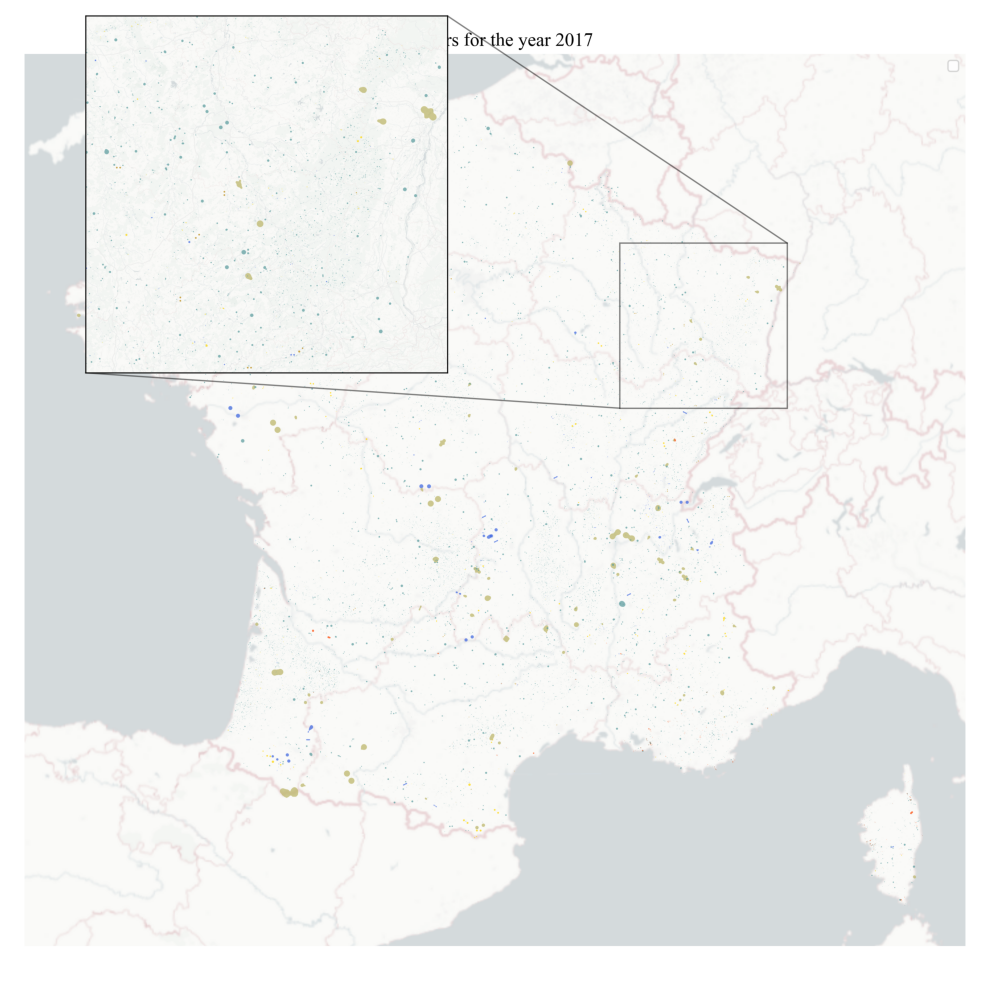

In [21]:
#make an animation with the four previsous figures saved at os.path.join(folder, f'clusters_{year}.png') 
#use matplotlib and dpi=300
dpi = 150
import matplotlib.pyplot as plt
import os

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

def update(frame):
    img = plt.imread(os.path.join(folder, f'clusters_{frame}_bbox{bbox_name}_t{threshold}.png'))
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    
ani = FuncAnimation(fig, update, frames=[2017, 2018, 2019, 2020], repeat=False)
ani.save(os.path.join(folder, f'clusters_animation_bbox{bbox_name}_t{threshold}_dpi{dpi}.gif'), writer='ffmpeg', fps=1, dpi=dpi)


### Reliability Clusters 

In [63]:
import os
import matplotlib.pyplot as plt
import contextily as ctx
from tqdm import tqdm
from shapely.geometry import shape
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

bbox_name = 'les_landes'
bbox = bboxs[bbox_name]
# Your custom_color_mapping and clusters data loading code remains unchanged.
for year in tqdm([2017, 2018, 2019, 2020]):
    clusters_year = clusters[(clusters.Start_Date.dt.year == year) | (clusters.End_Date.dt.year == year)]

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    clusters_year.plot(column='Spatial_threshold', ax=ax, cmap='viridis', legend=True, alpha=0.75, vmin=0, vmax=1, legend_kwds={'shrink': 0.5})

    ax.set_title(f'Clusters for the year {year}', fontname='Times New Roman', fontsize=14)
    ax.set_axis_off()
    
    # Adding a basemap for the whole of France
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False, crs=clusters_year.crs.to_string(), zoom=6)

    # Create an inset axis for Les Landes zoom-in
    axins = inset_axes(ax, width="40%", height="40%", loc='upper right',
                       bbox_to_anchor=(0.05, 0.05, 1, 1),
                       bbox_transform=ax.transAxes)

    clusters_year.plot(column='Spatial_threshold', ax=axins, cmap='viridis', alpha=0.75, vmin=0, vmax=1)
    axins.set_xlim(bbox['xmin'], bbox['xmax'])
    axins.set_ylim(bbox['ymin'], bbox['ymax'])
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    axins.set_xticks([])
    axins.set_yticks([])
    ax.indicate_inset_zoom(axins, edgecolor="black")
    # Adding a basemap for the zoomed-in view
    ctx.add_basemap(axins, source=ctx.providers.CartoDB.PositronNoLabels, attribution=False, crs=clusters_year.crs.to_string(), zoom=10)

    fig.tight_layout()
    fig.savefig(os.path.join(folder, f'clusters_{year}_bbox{bbox_name}_reliability.png'), dpi=300)


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [02:01<00:00, 30.28s/it]


AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 1000x1000 with 3 Axes>

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 1000x1000 with 3 Axes>

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 1000x1000 with 3 Axes>

AttributeError: 'NoneType' object has no attribute '_get_renderer'

<Figure size 1000x1000 with 3 Axes>

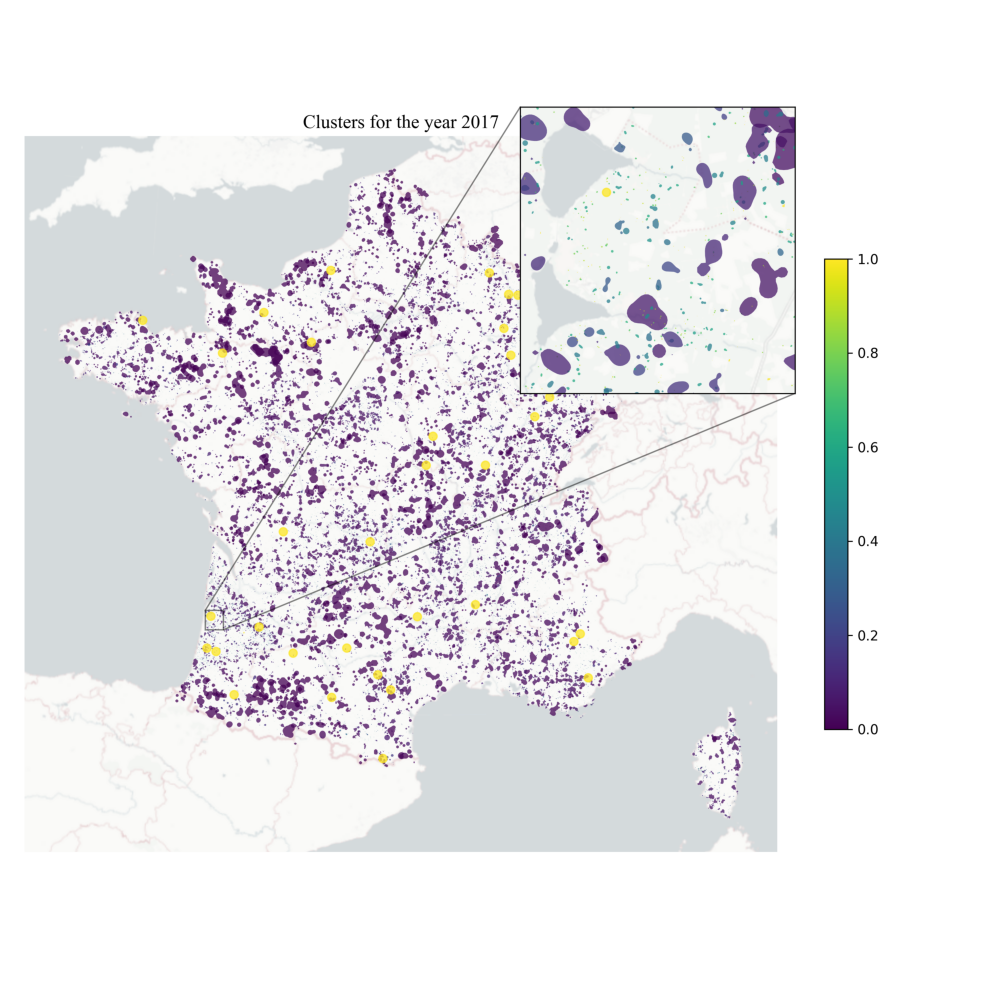

In [71]:
#make an animation with the four previsous figures saved at os.path.join(folder, f'clusters_{year}.png') 
#use matplotlib and dpi=300

import matplotlib.pyplot as plt
import os

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

def update(frame):
    img = plt.imread(os.path.join(folder, f'clusters_{frame}_bbox{bbox_name}_reliability.png'))
    ax.imshow(img)
    ax.set_axis_off()
    plt.tight_layout()
    
ani = FuncAnimation(fig, update, frames=[2017, 2018, 2019, 2020], repeat=False)
ani.save(os.path.join(folder, f'clusters_animation_bbox{bbox_name}_reliability_dpi150.gif'), writer='ffmpeg', fps=1, dpi=150)


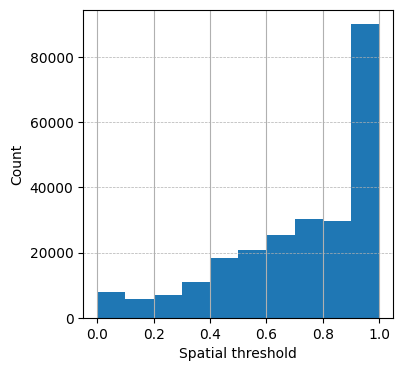

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

clusters.Spatial_threshold.hist(ax=ax)
ax.set_xlabel('Spatial threshold')
ax.set_ylabel('Count')
ax.grid(axis='y', linestyle='--', lw=0.5)

## Disturbances polygons [too much time]



1078it [00:15, 71.13it/s]00<?, ?it/s]
1891it [00:25, 73.24it/s]
1864it [00:28, 64.57it/s]
524it [00:07, 69.97it/s]
125it [00:01, 69.27it/s]
52000it [12:06, 71.61it/s]
  0%|          | 0/4 [13:30<?, ?it/s]


KeyboardInterrupt: 

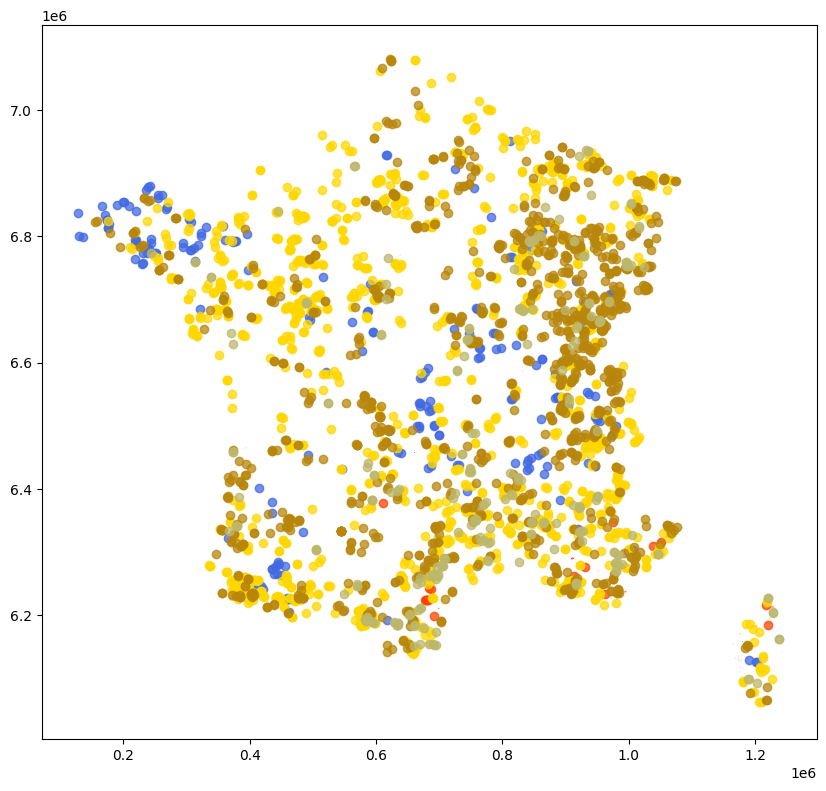

In [29]:
#display one fig per year with the clusters
custom_color_mapping = {
    'fire': 'orangered',
    'storm': 'royalblue',
    'biotic-dieback': 'gold',
    'biotic-mortality': 'darkgoldenrod',  # Yellow-brown
    'drought-dieback': 'darkkhaki',
    'anthropogenic': 'cadetblue'  # Light blue/grey
}

#use the dict above to map the color of the clusters
import matplotlib.pyplot as plt
import contextily as ctx
from tqdm import tqdm 
for year in tqdm([2017, 2018, 2019, 2020]):
    #filter clusters
    clusters_year = clusters[ (clusters.Start_Date.dt.year == year) | (clusters.End_Date.dt.year == year) ]

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    #plot per class with the right color
    for class_, color in custom_color_mapping.items():
        clusters_year_class = clusters_year[ clusters_year.Class == class_ ] 

        list_gdf = []
        for name, row in tqdm(clusters_year_class.iterrows()):
            g = communities[communities.index.isin(row.Indexes)]
            g['Cluster_Class'] = row['Class']
            list_gdf.append(g)

        gdf_polygons = gpd.GeoDataFrame(pd.concat(list_gdf), geometry='geometry', crs=clusters_year_class.crs)

        gdf_polygons.plot(ax=ax, color=color, label=class_, alpha=0.75)

    #set title in TimesNewRoman
    ax.set_title(f'Polygons for the year {year}', fontname='Times New Roman', fontsize=14)
    ax.set_axis_off()
    ax.legend()
    plt.show()

# Trash

In [25]:
ddataset.keys()

dict_keys(['dfde', 'hm', 'nfi', 'senfseidl', 'bdiff', 'cdi', 'forms', 'firepolygons'])

In [27]:
dfde.shape

(34, 10)

In [28]:
(dfde.geometry.area / 10**6 < 150).sum()

33

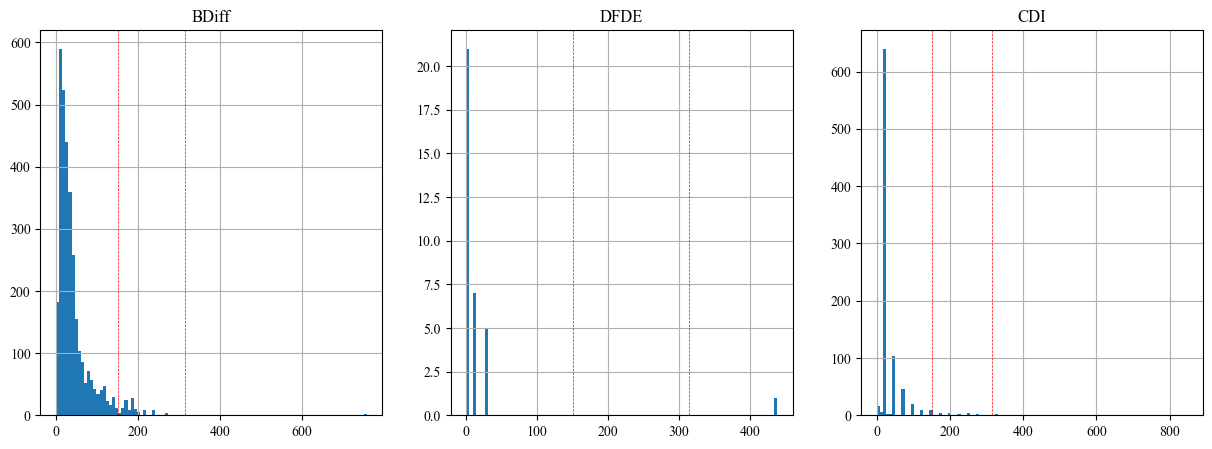

In [26]:
#3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
bdiff, dfde, cdi = ddataset['bdiff'], ddataset['dfde'], ddataset['cdi']
(bdiff.geometry.area / 1e6).hist(bins=100, ax=axes[0])
(dfde.geometry.area / 1e6).hist(bins=100, ax=axes[1])
(cdi.geometry.area / 1e6).hist(bins=100, ax=axes[2])

#add title
axes[0].set_title('BDiff')
axes[1].set_title('DFDE')
axes[2].set_title('CDI')

#add two vertical lines one at 314 and one at 150
for ax in axes:
    ax.axvline(314, linestyle='--', color='r', lw=0.5)
    ax.axvline(150, linestyle='--', color='r', lw=0.5)